In [7]:
!pip install ir_datasets
!pip install deep_translator
!pip install rank_bm25
!pip install ir_measures
!pip install razdel
!pip install stopwordsiso

In [8]:
import ir_datasets
import nltk
from collections import defaultdict
from deep_translator import GoogleTranslator
from tqdm.notebook import tqdm
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from rank_bm25 import BM25Okapi
import string
from rank_bm25 import BM25Okapi
import ir_measures
from ir_measures import nDCG, MAP, RBP, Recall, Qrel, ScoredDoc
from itertools import chain
from razdel import tokenize
from nltk.stem.snowball import SnowballStemmer
import string
import stopwordsiso
from stopwordsiso import stopwords
import pickle
import matplotlib.pyplot as plt
import pandas as pd



### Load documents

In [9]:
dataset = ir_datasets.load("neuclir/1/ru/trec-2023")
dataset

Dataset(id='neuclir/1/ru/trec-2023', provides=['docs', 'queries', 'qrels'])

In [10]:
russian_documents = [(doc.doc_id, doc.title, doc.text) for doc in tqdm(dataset.docs_iter())]
english_queries = [(query.query_id, query.title) for query in dataset.queries_iter()]
qrels = [(qrel.query_id, qrel.doc_id, qrel.relevance) for qrel in dataset.qrels_iter()]

0it [00:00, ?it/s]

In [11]:
# we sample the documents which are mentioned in qrels
qrels_ids = {entry[1] for entry in tqdm(qrels)}
russian_documents_subset = [doc for doc in tqdm(russian_documents) if doc[0] in qrels_ids]
len(russian_documents_subset)

  0%|          | 0/25634 [00:00<?, ?it/s]

  0%|          | 0/4627543 [00:00<?, ?it/s]

24871

### Helper functions

In [12]:
def evaluate(qrels, result):

    runs = [
        ScoredDoc(query_id=query_id, doc_id=doc_id, score=score)
        for query_id, doc_id, score in result
    ]

    metrics = [
        ir_measures.nDCG @ 20,   # nDCG@20
        ir_measures.AP,          # Average Precision
        #ir_measures.RBP(rel=1),  # Relevance Based Precision
        ir_measures.R @ 100,     # Recall@100
        ir_measures.R @ 1000     # Recall@1000
    ]

#     scores = ir_measures.calc_aggregate([nDCG@20, MAP, RBP(rel=1), Recall@100, Recall@1000], qrels, runs)
    scores = ir_measures.calc_aggregate([nDCG@20, MAP, Recall@100, Recall@1000], qrels, runs)

    return scores


def rbp(retrieved_results, qrels, p=0.8):
    # Create a dictionary of relevant documents for each query from qrels
    qrels_dict = defaultdict(set)

    # Unpack qrels and store relevant documents per query_id
    for qrel in qrels:
        query_id = qrel.query_id
        doc_id = qrel.doc_id
        relevance = qrel.relevance
        if relevance > 0:
            qrels_dict[query_id].add(doc_id)

    # Group the retrieved results by query_id
    grouped_retrieved_results = defaultdict(list)
    for query_id, doc_id, score in retrieved_results:
        grouped_retrieved_results[query_id].append((doc_id, score))

    # Initialize the rbp_scores dictionary
    rbp_scores = {}

    # Iterate over the grouped retrieved results
    for query_id, retrieved_docs in grouped_retrieved_results.items():
        score = 0
        # Rank each document for the query
        for rank, (doc_id, _) in enumerate(retrieved_docs, start=1):
            if doc_id in qrels_dict.get(query_id, set()):
                score += (1 - p) * (p ** (rank - 1))
        rbp_scores[query_id] = score

    return rbp_scores

def print_document(document_id):
    print(next((doc for doc in russian_documents if doc[0] == document_id), None))


def translate_query(query):
    translated_text = GoogleTranslator(source='auto', target='ru').translate(query[1])
    translated_tuple = (query[0], translated_text)

    return translated_tuple


def combine_documents(documents):
    combine_documents =  list(map(lambda doc: (doc[0], doc[1] + ' ' + doc[2]), documents))
    return combine_documents



def preprocess(text, remove_stop: bool=True) -> list:
    """
    :text: str, text of the corresponding document
    :param remove_stop: bool indicating if stopwords should be removed (default True)

    :return: list(str) of tokens, stemmed, with removed punctuation
    """


    tokens = [_.text for _ in list(tokenize(text))]

    preprocessed =[]

    stemmer = SnowballStemmer("russian")
    stopwords_ru = stopwords("ru")
    punct = string.punctuation + "«»" + "—" + '–'

    for t in tokens:
        if t in punct:
            continue
        if remove_stop and t.lower() in stopwords_ru:
            continue
        preprocessed.append(stemmer.stem(t))

    return preprocessed


**Preprocessing**

In [13]:
# To search on both document title and text, we will concatenate them, obtaining pairs (document_id, full text (title+text))
combined_documents = combine_documents(russian_documents_subset)
print(combined_documents[-1])

('20bc2d7b-91d1-428b-aa54-ef112e8a1e69', 'Экс-замминобороны США: ядерную войну запустит искусственный интеллект Вашингтон, , 06:51 — REGNUM О существенной опасности искусственного интеллекта в случае использования его военными заявил бывший заместитель министра обороны США Роберт Уорк, передает Breaking Defense.\n\nИскусственный интеллект Цитата из к/ф «Космическая одиссея 2001 года». Реж. Стэнли Кубрик. 1968. США — Великобритания\n\nПо мнению бывшего сотрудника Пентагона, если допустить искусственный интеллект (ИИ) к принятию решений, то существует вероятность, что имеющиеся риски будут оценены им неверно, и ядерное оружие будет применено в ситуации, когда реальной угрозы не будет существовать.\n\n«Представьте, что в системе управления ядерным оружием есть прогностическая система ИИ, которая запускается по определенным параметрам, — сказал он. — Это гораздо, гораздо, гораздо более тревожная перспектива, чем все опасности, что вы можете представить в связи с применением индивидуального

In [14]:
#Then, we preprocess all documents (tokenization, dropping punctuation and stopwords, stemming)
preprocessed_documents = [
    (doc_id, preprocess(doc_text))
    for doc_id, doc_text in combined_documents
]

In [15]:
#Next, we translate all queries to Russian
translated_queries = []
for query in english_queries:
  translated_queries.append(translate_query(query))

In [16]:
print(translated_queries[0:5])

[('200', 'Коррупция Взяточничество Спортивная федерация Олимпиада'), ('201', 'Китайские инвестиции в Иран'), ('202', 'Новые технологии, точное земледелие, интеллектуальное земледелие, сельское хозяйство'), ('203', 'Эвер Гивен застрял'), ('204', 'Штраф допинг спорт стоп')]


In [17]:
# we will extract provided machine translation of the queries for comparison
mt_queries = [(query.query_id, query.mt_title) for query in dataset.queries_iter()]
print(mt_queries[0:5])

[('200', 'Олимпийские игры Федерации спортивных игр коррупции Хруппов'), ('201', 'Китайские инвестиции в Иран'), ('202', 'Новые технологии, точное сельское хозяйство, умное сельское хозяйство, сельское хозяйство'), ('203', 'Когда -либо дал застрял'), ('204', 'Спортивная остановка пенальти')]


In [18]:
print(english_queries[0:5])

[('200', 'Corruption Bribery Sports Federation Olympics'), ('201', 'China investment in Iran'), ('202', 'Emerging technologies, precision farming, smart farming, agriculture'), ('203', "Ever Given's Stuck"), ('204', 'Penalty doping sports stop')]


In [19]:
# combining the translations in one dataframe for a more convenient displaying
queries_comparison = {
    "query_id": [item[0] for item in english_queries],  # Extract query_id
    "english_queries": [item[1] for item in english_queries],  # Extract text
    "translated_queries": [item[1] for item in translated_queries],
    "mt_queries": [item[1] for item in mt_queries],
}

df = pd.DataFrame(queries_comparison)

df.set_index("query_id", inplace=True)
#pd.set_option('display.max_colwidth', None)

df


,english_queries,translated_queries,mt_queries
query_id,,,
200,Corruption Bribery Sports Federation Olympics,Коррупция Взяточничество Спортивная федерация ...,Олимпийские игры Федерации спортивных игр корр...
201,China investment in Iran,Китайские инвестиции в Иран,Китайские инвестиции в Иран
202,"Emerging technologies, precision farming, smar...","Новые технологии, точное земледелие, интеллект...","Новые технологии, точное сельское хозяйство, у..."
203,Ever Given's Stuck,Эвер Гивен застрял,Когда -либо дал застрял
204,Penalty doping sports stop,Штраф допинг спорт стоп,Спортивная остановка пенальти
...,...,...,...
271,nematode reanimation,реанимация нематод,реанимация нематоды
272,"Hanyu Yuzuru, figure skate, achievement","Ханю Юдзуру, фигурное катание, достижение","Hanyu Yuzuru, фигура катания, достижение"
273,iran embassy attack vienna,Иран посольство атака вена,Атака посольства Ирана Вена


In [20]:
# we will check how many query translation are identical
identical_queries = df['mt_queries'].str.lower() == df['translated_queries'].str.lower()

identical_count = identical_queries.sum()

print(f"Number of queries where mt_queries and translated_queries are identical (case-insensitive): {identical_count}")

Number of queries where mt_queries and translated_queries are identical (case-insensitive): 22


In [21]:
# we will display the rest of the queries for a more detailed manual study
non_identical_queries = df[df['mt_queries'].str.lower() != df['translated_queries'].str.lower()]

non_identical_queries

,english_queries,translated_queries,mt_queries
query_id,,,
200,Corruption Bribery Sports Federation Olympics,Коррупция Взяточничество Спортивная федерация ...,Олимпийские игры Федерации спортивных игр корр...
202,"Emerging technologies, precision farming, smar...","Новые технологии, точное земледелие, интеллект...","Новые технологии, точное сельское хозяйство, у..."
203,Ever Given's Stuck,Эвер Гивен застрял,Когда -либо дал застрял
204,Penalty doping sports stop,Штраф допинг спорт стоп,Спортивная остановка пенальти
206,Montreux Convention Istanbul Canal,Конвенция Монтрё Стамбульский канал,Монтрейс -конференция Стамбульский канал
207,Whale stranding Tasmania 2020,Киты выбросились на берег Тасмании в 2020 году,Кит Страйдинг Тасмания 2020
208,Russia oil export reduction,Сокращение экспорта нефти из России,Российское сокращение экспорта нефти
209,How Handcrafting Affects Health,Как ручная работа влияет на здоровье,Как ручной работы влияют на здоровье
213,"Coin collection, collecting coins, reasons","Коллекционирование монет, коллекционирование м...","Коллекция монет, коллекционирование монет, при..."


In [24]:
print(non_identical_queries.columns)

Index(['english_queries', 'translated_queries', 'mt_queries'], dtype='object')


In [28]:
# List of problematic mt_query translation
query_ids = ['203', '223', '242', '245', '249', '259', '267', '268']

problematic_translations = non_identical_queries.loc[query_ids]


# Display the filtered dataframe
pd.set_option('display.max_colwidth', None)
problematic_translations

,english_queries,translated_queries,mt_queries
query_id,,,
203,Ever Given's Stuck,Эвер Гивен застрял,Когда -либо дал застрял
223,Loujain Hathloul Women’s Rights,Права женщин Луджайн Хатлул,Loujain Hathloul Women Rights
242,Self-Driving Cars: Safety and Security Concerns,Беспилотные автомобили: проблемы безопасности,Автомобили с самостоятельным вождением: проблемы безопасности и безопасности
245,Tinnitus COVID-19,Шум в ушах при COVID-19,CHOVID-19 в ушах
249,UK fine Facebook Cambridge Analytica scandal,Скандал со штрафом от Великобритании Facebook Cambridge Analytica,Великобритания прекрасный Facebook Cambridge Analytica Scandal
259,Kimetsu no Yaiba manga sales,Продажи манги Kimetsu no Yaiba,Kimetsu no Yaiba Manga Sales
267,All Nippon Airways airline ranking 2018,Рейтинг авиакомпаний All Nippon Airways 2018 г.,All Nippon Airways Ranking 2018
268,Engineering projects made by the Youtuber Mark Rober,"Инженерные проекты, созданные ютубером Марком Робером","Инженерные проекты, сделанные YouTuber Mark Rober"


ALthough the difference is not drastic, the queries translated by deep_translator appear to have a better quality. We will use them for the information retrieval task

In [29]:
#Then, we preprocess every translated query (tokenization, dropping punctuation and stopwords, stemming)
preprocessed_queries = [
    (query_id, preprocess(query_text))
    for query_id, query_text in translated_queries
]

In [30]:
print(preprocessed_queries[0:5])

[('200', ['коррупц', 'взяточничеств', 'спортивн', 'федерац', 'олимпиад']), ('201', ['китайск', 'инвестиц', 'ира']), ('202', ['нов', 'технолог', 'точн', 'земледел', 'интеллектуальн', 'земледел', 'сельск', 'хозяйств']), ('203', ['эвер', 'гив', 'застря']), ('204', ['штраф', 'допинг', 'спорт', 'стоп'])]


**Word-Overlap based Methods**

TF-IDF

For the implementation of TF-IDF approach we will employ TfidfVectorizer from scikit-learn. We want to first create TF-IDF matrix based on our collection and then be able to pass queries and for each query get a list of documents with their respective cosine similarities ranked in descending order. For that, we will create a class of TF-IDF model with a ranking method.
In this notebook we implement the best-performing configuratoin out of TF-IDF experiments.

In order to bypass the inbuilt tokenization and pass as input lists of tokens as documents, we create an additional "dummy" function (solution suggested by David Batista https://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/). Instead of taking raw term frequencies, we will use logarithm tf weighing: 1 + log(tf), by modifying sublinear_tf parameter of the vectorizer.

In [58]:
# dummy fucntion is needed to be able
def dummy_function(x):
    return x


class TfIdfModel:
    def __init__(self, collection):
        # extracting  document IDs and texts
        self.doc_ids, doc_texts = zip(*collection)

        # initializing vectorizer that can be applied to tokenized documents
        self.vectorizer = TfidfVectorizer(
            analyzer='word',
            tokenizer=dummy_function,
            preprocessor=dummy_function,
            token_pattern=None,
            sublinear_tf=True
        )

        # fitting the vectorizer on the collection texts and transform
        self.tfidf_matrix = self.vectorizer.fit_transform(doc_texts)

    def rank_documents(self, query, rank_length):
        # extracting query ID and text
        query_id, query_text = query

        # transforming the query text into the vector space
        query_vector = self.vectorizer.transform([query_text])

        # Compute cosine similarities between query vector and precomputed matrix
        cosine_similarities = cosine_similarity(query_vector, self.tfidf_matrix).flatten()

        # Pair each document ID with its corresponding cosine similarity score
        scored_documents = [(doc_id, similarity) for doc_id, similarity in zip(self.doc_ids, cosine_similarities)]

        # Sort documents by similarity score in descending order
        sorted_documents = sorted(scored_documents, key=lambda x: x[1], reverse=True)

        # Return ranked data
        ranked_data = [(query_id, uuid, value) for uuid, value in sorted_documents[:rank_length]]
        return ranked_data

In [59]:
# we will fit the model on out document collection
model = TfIdfModel(preprocessed_documents)

In [60]:
ranked_tfidf = []
for query in tqdm(preprocessed_queries):
    scores_tfidf = model.rank_documents(query, 1000)
    ranked_tfidf.append(scores_tfidf)

flat_list_tfidf = list(chain.from_iterable(ranked_tfidf))

  0%|          | 0/76 [00:00<?, ?it/s]

In [61]:
print(flat_list_tfidf[:5])

[('200', 'dbc0d493-44a5-4f5f-84ce-066d341a44a6', 0.32436549951536825), ('200', '21a96c19-6e65-4ad7-a5f1-bc51db6cd15c', 0.2488488635821852), ('200', '491ae781-eb12-4dcf-be5a-8efe25cad1d3', 0.23263991270871823), ('200', 'd7fbeb98-1726-4365-af82-d4e156cbc198', 0.22630189324836872), ('200', 'fa560d7f-2f67-4fb1-a93c-3a51a0c539a6', 0.2215251540497728)]


BM25

We use the BM25 implementation from rank-bm25 python package. https://pypi.org/project/rank-bm25/
The best performing model in the experiments is the Okapi model (Robertson et al).

In [38]:
def bm25(query, documents):

    query_number = query[0]
    query_tokens = query[1]
    document_ids = [item[0] for item in documents]

    # passing the documents and initialize BM25
    corpus = [doc[1] for doc in documents]
    bm25 = BM25Okapi(corpus)

    # getting BM25 scores for the query tokens
    scores = bm25.get_scores(query_tokens)

    # combining query_number, document_ids, and scores into the required format
    scored_documents = [(doc_id, score) for doc_id, score in zip(document_ids, scores)]

    sorted_documents = sorted(scored_documents, key=lambda x: x[1], reverse=True)

    ranked_data = [(query_number, uuid, value) for uuid, value in sorted_documents[:1000]]

    return ranked_data

In [39]:
ranked_bm25 = []
for query in tqdm(preprocessed_queries):
    scores_bm25 = bm25(query, preprocessed_documents)
    ranked_bm25.append(scores_bm25)

flat_list_bm25 = list(chain.from_iterable(ranked_bm25))

  0%|          | 0/76 [00:00<?, ?it/s]

In [40]:
print(flat_list_bm25[:5])

[('200', 'fa560d7f-2f67-4fb1-a93c-3a51a0c539a6', 23.28870824007913), ('200', 'd7fbeb98-1726-4365-af82-d4e156cbc198', 21.798941281005405), ('200', 'c6fa30d0-dbfc-4bc3-892c-5e95a65f46b1', 21.14968436080987), ('200', '1a49ac53-27fa-45bc-abda-f33927daaf28', 20.798231676157467), ('200', 'e9b85084-2200-4812-989b-dd7ee8bacfbd', 20.791606684961053)]


**Evaluation of word-overlap based methods**

In [42]:
qrels = [
    ir_measures.Qrel(query_id=query_id, doc_id=doc_id, relevance=score)
    for query_id, doc_id, score in qrels
]

TF-IDF evaluation

In [62]:
performance_tfidf = evaluate(qrels, flat_list_tfidf)

In [65]:
# getting average RBP(rel=1) scores and adding them to performance measures dictionary
RBP_tfidf = rbp(flat_list_tfidf, qrels)
RBP_1_tfidf = sum(RBP_tfidf.values()) / len(RBP_tfidf)
performance_tfidf["RBP(rel=1)"] = RBP_1_tfidf

In [66]:
print("Evaluation Metrics (TF-IDF):")
for metric, value in performance_tfidf.items():
    print(f"{metric}: {value}")

Evaluation Metrics (TF-IDF):
AP: 0.28001360925051477
R@1000: 0.8855943757303283
nDCG@20: 0.3196050100708838
R@100: 0.48378915616448215
RBP(rel=1): 0.3646633901989546


BM25 evaluation

In [46]:
performance_bm25 = evaluate(qrels, flat_list_bm25)

In [67]:
RBP_bm25 = rbp(flat_list_bm25, qrels)
RBP_1_bm25 = sum(RBP_bm25.values()) / len(RBP_bm25)
performance_bm25["RBP(rel=1)"] = RBP_1_bm25

In [68]:
print("Evaluation Metrics (BM25):")
for metric, value in performance_bm25.items():
    print(f"{metric}: {value}")

Evaluation Metrics (BM25):
AP: 0.33916640326369557
R@1000: 0.8890930790435744
nDCG@20: 0.41167936939433875
R@100: 0.5054130943731772
RBP(rel=1): 0.45496377037131436


**Improving BM25 results with query expansion**

To determine which terms need to be included in the query, we will use the relevance model that will for each query find top N terms appearing in top K ranked documents. The terms will be ranked by the sum of the probabilities of the term being in a relevant document weighted by the original score assigned to the document at previous ranking.
The best parameters out of experiments are mu = 1, k = 10, n = 10.

In [50]:
# for our relevance model, we will define a separate class

class LavrenkoRelevanceModel:
    def __init__(self, collection, preranking, mu=2000, top_k=10, top_n_terms=10):
        """
        :param tcollection: List of tokenized documents [(doc_id, [tokens])]
        :param preranking: scores [(query_id, doc_id, score)] obtained by previous ranking
        :param mu: Dirichlet smoothing parameter
        :param top_k: Number of top-ranked documents to use for relevance model
        :param top_n_terms: Number of terms to expand the query with
        """
        self.documents = {doc_id: tokens for doc_id, tokens in collection}
        self.preranking = preranking
        self.mu = mu
        self.top_k = top_k
        self.top_n_terms = top_n_terms

        # building a background collection model
        self.background_model = self._compute_background_model()

    def _compute_background_model(self):
        """Compute collection-wide term frequencies for Dirichlet smoothing."""
        corpus = []
        for tokens in self.documents.values():
            corpus.extend(tokens)

        total_terms = len(corpus)
        term_frequencies = Counter(corpus)
        return {term: freq / total_terms for term, freq in term_frequencies.items()}

    def _get_top_k_documents(self, query_id):
        """Retrieve the top-k documents for a given query."""
        top_docs = [
            (doc_id, score)
            for q_id, doc_id, score in self.preranking
            if q_id == query_id
        ]
        top_docs = sorted(top_docs, key=lambda x: x[1], reverse=True)[:self.top_k]
        return top_docs

    def _term_probability_given_document(self, term, document_id):
        """Compute P(w|d) for a term given a document."""
        tokens = self.documents[document_id]
        term_count = tokens.count(term)
        doc_length = len(tokens)
        P_w_C = self.background_model.get(term, 1e-12)
        return (term_count + self.mu * P_w_C) / (doc_length + self.mu)

    def _term_probability_given_query(self, term, query_id):
        """Compute P(w|q) for a term given a query."""
        top_docs = self._get_top_k_documents(query_id)
        probability = 0

        for doc_id, bm25_score in top_docs:
            P_w_d = self._term_probability_given_document(term, doc_id)
            probability += P_w_d * bm25_score

        return probability

    def expand_query(self, query_id, query_tokens):
        """Expand a query using the Lavrenko relevance model."""
        # calculating P(w|q) for all terms in top-k documents
        top_docs = self._get_top_k_documents(query_id)
        all_terms = set()
        for doc_id, _ in top_docs:
            all_terms.update(self.documents[doc_id])

        term_probabilities = {
            term: self._term_probability_given_query(term, query_id)
            for term in all_terms
        }

        # ranking terms by P(w|q) and select top n terms
        ranked_terms = sorted(term_probabilities.items(), key=lambda x: x[1], reverse=True)
        top_terms = [term for term, _ in ranked_terms[:self.top_n_terms]]

        # combining original query with expanded terms
        expanded_query = query_tokens + top_terms
        return query_id, expanded_query




In [51]:
# Instantiate and expand queries
lavrenko_model = LavrenkoRelevanceModel(preprocessed_documents, flat_list_bm25, mu=1, top_k=10, top_n_terms=10)
expanded_queries = [
    lavrenko_model.expand_query(query_id, query_tokens)
    for query_id, query_tokens in preprocessed_queries
]

In [52]:
# Print expanded queries
print("Expanded Queries:")
for query_id, expanded_query in expanded_queries:
    print(f"{query_id}: {expanded_query}")

Expanded Queries:
200: ['коррупц', 'взяточничеств', 'спортивн', 'федерац', 'олимпиад', 'коррупц', 'взяточничеств', 'фиф', 'международн', 'мок', 'федерац', 'спортивн', 'президент', 'власт', 'организац']
201: ['китайск', 'инвестиц', 'ира', 'ира', 'кита', 'инвестиц', 'китайск', 'иранск', 'доллар', 'млрд', 'иран', 'сектор', 'нефт']
202: ['нов', 'технолог', 'точн', 'земледел', 'интеллектуальн', 'земледел', 'сельск', 'хозяйств', 'хозяйств', 'технолог', 'земледел', 'сельск', 'точн', 'цифров', 'систем', 'сельскохозяйствен', 'цифровизац', 'област']
203: ['эвер', 'гив', 'застря', 'суэцк', 'кана', 'контейнеровоз', 'эвер', 'застря', 'гив', 'судн', 'суд', 'канал', 'Ever']
204: ['штраф', 'допинг', 'спорт', 'стоп', 'допинг', 'штраф', 'спортсмен', 'спорт', 'закон', 'использован', 'запрещен', 'рубл', 'росс', 'законопроект']
205: ['чист', 'энерг', 'применен', 'практик', 'тенденц', 'энерг', 'источник', 'электроэнерг', 'чист', 'возобновля', 'применен', 'развит', 'технолог', 'нов', 'стран']
206: ['конвенц'

In [53]:
# Run BM25 on expanded queries
ranked_bm25_LRM = []
for query in tqdm(expanded_queries):
    scores_bm25_LRM = bm25(query, preprocessed_documents)
    ranked_bm25_LRM.append(scores_bm25_LRM)

flat_list_bm25_LRM = list(chain.from_iterable(ranked_bm25_LRM))

  0%|          | 0/76 [00:00<?, ?it/s]

In [54]:
print(flat_list_bm25_LRM[:5])

[('200', 'c6fa30d0-dbfc-4bc3-892c-5e95a65f46b1', 64.16488801260344), ('200', 'e9b85084-2200-4812-989b-dd7ee8bacfbd', 62.025006403774206), ('200', 'dd156442-967c-4cf4-9640-f2ae95d4075c', 60.87406781154567), ('200', '40b1d7b9-856b-416f-9e9e-daa14daab532', 54.27395403892513), ('200', '2fb2cba8-5d76-4dc7-8c2e-80dbd2870eb8', 53.57633144834916)]


In [55]:
# Evaluate the performance on expanded queries
performance_bm25_LRM = evaluate(qrels, flat_list_bm25_LRM)

In [56]:
RBP_bm25_LRM = rbp(flat_list_bm25_LRM, qrels)
RBP_1_bm25_LRM = sum(RBP_bm25_LRM.values()) / len(RBP_bm25_LRM)
performance_bm25_LRM["RBP(rel=1)"]=RBP_1_bm25_LRM

In [57]:
print("Evaluation Metrics (BM25_LRM):")
for metric, value in performance_bm25_LRM.items():
    print(f"{metric}: {value}")

Evaluation Metrics (BM25_LRM):
AP: 0.3828646127084423
R@1000: 0.9204044831468705
nDCG@20: 0.4341763439703586
R@100: 0.5505193775570902
RBP(rel=1): 0.47271449980124286


In [69]:
import pandas as pd

# we will collect the results in one dataframe
tfidf_results = {
    "NDCG@20": 0.3196050100708838,
    "MAP": 0.28001360925051477,
    "RBP(rel=1)": 0.3646633901989546,
    "Recall@100": 0.48378915616448215,
    "Recall@1000": 0.8839690860680056,
}


bm25_results = {
    "NDCG@20": 0.41167936939433875,
    "MAP": 0.33916640326369557,
    "RBP(rel=1)": 0.45496377037131436,
    "Recall@100": 0.5054130943731772,
    "Recall@1000": 0.8890930790435744,
}


bm_25_LRM_results = {
    "NDCG@20": 0.4341763439703586,
    "MAP": 0.45496377037131436,
    "RBP(rel=1)": 0.47271449980124286,
    "Recall@100": 0.5505193775570902,
    "Recall@1000": 0.9204044831468705,
}


comparison_data = {
    "Metric": ["NDCG@20", "MAP", "RBP(rel=1)", "Recall@100", "Recall@1000"],
    "TF-IDF": list(tfidf_results.values()),
    "BM25": list(bm25_results.values()),
    "BM25 with LRM": list(bm_25_LRM_results.values()),
}

df = pd.DataFrame(comparison_data)

In [70]:
print(df)

        Metric    TF-IDF      BM25  BM25 with LRM
0      NDCG@20  0.319605  0.411679       0.434176
1          MAP  0.280014  0.339166       0.454964
2   RBP(rel=1)  0.364663  0.454964       0.472714
3   Recall@100  0.483789  0.505413       0.550519
4  Recall@1000  0.883969  0.889093       0.920404


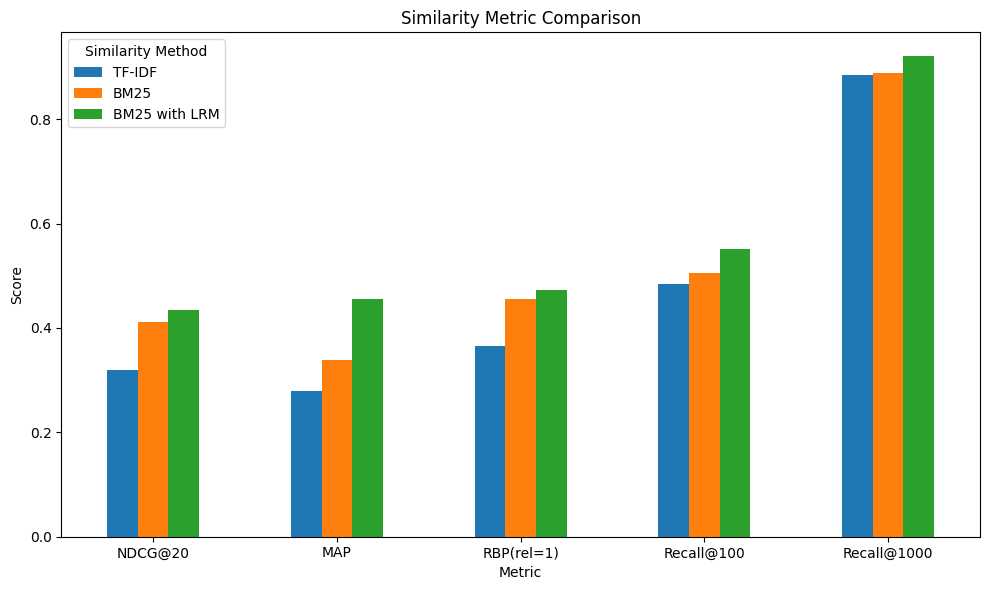

In [71]:
# we will present the coparison as a bar plot
df.set_index("Metric").plot(kind="bar", figsize=(10, 6))
plt.title("Similarity Metric Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Similarity Method")
plt.tight_layout()
plt.show()